### First, I need ti create a grid of point features roughly the size of Washington State.
I need 3 point shapefiles, 0.075 degree spacing for statewide, 0.05 degree spacing for large districts, and 0.01 for small districts. I create each by changing the variable 'by'. After each, I opened these in QGIS and select only the points that were within each of my target geographic unit's ploygons (Washington state, or else one of the 10 congressional districts. I then save each. The unclipped grids are saved as a geographic identifier (wa, cd01, cd02, etc...), then a three digit number (representing the degree spacing) followed by 'grid'. The clipped features follow the same naming convention, but with the suffix 'pts'. All of these can be found in the Shapes folder.

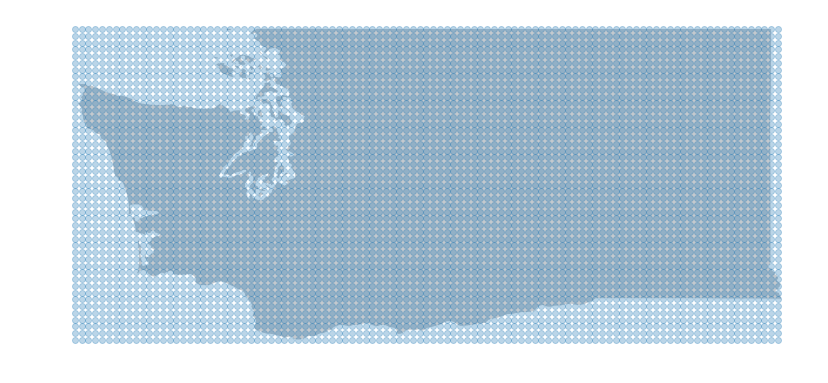

In [60]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame
from shapely.geometry import Polygon
import matplotlib as mpl

%matplotlib inline 
mpl.rcParams['figure.figsize'] = (14,14)

nan = 'np.nan'
bing_api_key = ''
crs = {'init': 'epsg:4326'}

shp = 'Shapes/States/cb_2017_us_state_500k.shp'
us = gpd.read_file(shp)
wa = us[us['STUSPS']=="WA"]
by = .075    #trying a slightly larger grid to keep from crashing everything.


pts_grid = (
    pd.concat([pd.DataFrame({'pts_lon' : np.arange(wa.bounds['minx'], wa.bounds['maxx'], by)})
               , (pd.DataFrame({'pts_lat' : np.arange(wa.bounds['miny'], wa.bounds['maxy'], by)})
                  .pivot(columns = 'pts_lat', values = 'pts_lat'))]
        , axis = 1
             )
    .replace(method='ffill')
    .replace(method='bfill')
    .melt(id_vars=['pts_lon'])
    .drop('variable', 1)
    .rename(columns = {'value' : 'pts_lat'})
    .reset_index()
    .rename(columns={"index": "point_id"})
)
geometry_pts = [Point(xy) for xy in zip(pts_grid.pts_lon, pts_grid.pts_lat)]
gdf_pts_grid = GeoDataFrame(pts_grid, crs=crs, geometry=geometry_pts)

wa_plot = wa.plot(color='#C4C9CE', edgecolor='white')

(    gdf_pts_grid
        .plot(ax=wa_plot, alpha = .3)
        .set_axis_off())



#save to shapefile so I can clip them in QGIS
#gdf_pts_grid.to_file("WA_01grid.shp")
#gdf_pts_grid

This block is just to see how the points look when plotted, so I can double-check that I clipped them right in QGIS:

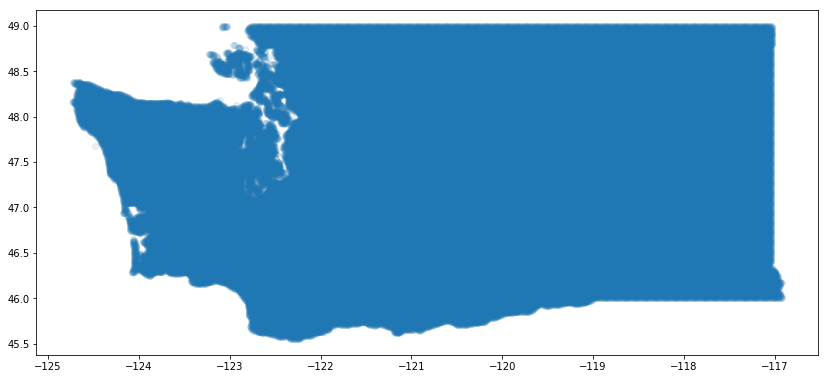

In [22]:
%matplotlib inline 
mpl.rcParams['figure.figsize'] = (14,14)

pts = 'WA_01pts.shp'
wa_pt_grid = gpd.read_file(pts)

wa_pt_grid.plot(alpha = .1)



### Next, we need to set up a distance matrix.
A distance matrix (or similarity matrix) is a table of N by N dimensions. The cell values corresponding to each row and column contains a 'similarity' between the heading and index (first row and column) values. In this example, the row and heading are populated using the list of points we created above. We want to use travel time between each combination of points as the similarity, instead of the typical euclidean distance. This is what we will feed into our Multidimensional Scaling script later. 

One important note: if the heading row and the index column are identical, then row 'X' and column 'Y' will have the same value as row 'Y' column 'X'. We can use this symmetry to reduce the number of geocoding requests we need to make. I do this using the itertools library function called combinations. Combinations looks at a list of values, and returns a second list of all the possible unique combinations that exist within that list. Check out the code comments below for an example.

Lets try this on something smaller. In the code block below, I take a sample point geometry set, clipped by district, and attempt to run the Bing geocoding API in order to build my distance matrix.
Conngressional distric 9 is one of the smallest, but I use the larges (0.075 degree) grid spacing to limit the number of points. This speeds things up a bit in case I need to run it multiple times.


In [94]:
from itertools import combinations
from random import randint
import json
from requests.exceptions import HTTPError
from urllib.error import URLError
import simplejson
import urllib
from datetime import datetime
from decimal import Decimal

file = 'Shapes/09/CD09_05pts.shp'
CDgrid = gpd.read_file(file)

#zip lat/long to single column (easier than dealing with shapely geometry)
CDgrid['lat,long'] = list(zip(CDgrid.pts_lat, CDgrid.pts_lon))

#create a list of all coordinates so I can write this to NxN matrix
xytups = CDgrid['lat,long'].tolist()

#find all unique combinations of list entries, removes duplicate geocoding (assuming travel time from A to B = B to A.)
unicombos = [comb for comb in combinations(xytups, 2)]  

#these next lines let me see what I'm up against, computationally - for CD09_05pts, I get 27 points, 351 unique combinations, and 729 possible combinations to work with.
#pointcount = len(xytups)
#totalcombinations = len(xytups)*len(xytups)
#print(pointcount)
#print(len(unicombos)) 
#print(totalcombinations)
   
#create the similarity matrix of n by n points
dmatrix = pd.DataFrame(index = xytups, columns = xytups)
dmatrix

#now, use the Bing API to populate the matrix. I need to use indexing to extract the data I need since I a tuple within a tuple.
# For example, str(unicombos[0][0][0])) selects the first unique combination, then the first point in the combo, then the first coordinate in that point: ((a,b),(c,d)) becomes 'a'.
length = len(unicombos)
key ='Your_Key'

for i in range(length):
    #select the target coordinate pairs in each unique tuple (origin, destination)
    origtup = unicombos[i][0]
    desttup = unicombos[i][1]
    
    #select the x and y coordinates for each of the pairs in the unique tuple
    origx = unicombos[i][0][0]
    origy = unicombos[i][0][1]    
    destx = unicombos[i][1][0]
    desty = unicombos[i][1][1]
     
    #cast coordinates to string for the REST API    
    strox = str(origx)
    stroy = str(origy)
    strdx = str(destx)
    strdy = str(desty)
    
    #calculate travel time
    #ttime = randint(1000,9999)
    try:
        url = 'http://dev.virtualearth.net/REST/V1/Routes/Driving?wp.0=' + strox + ',' + stroy + '&wp.1=' + strdx + ',' + strdy + '&key=' + key
        request = urllib.request.Request(url)
        response = urllib.request.urlopen(request)
    except HTTPError:
        ttime = Decimal('nan')
    except URLError:
        ttime = Decimal('nan')
    else:
        r = response.read().decode(encoding="utf-8")
        result = json.loads(r)
        ttime = (result["resourceSets"][0]["resources"][0]["travelDurationTraffic"])
    
    #populate the matrix
    dmatrix.loc[origtup, desttup]= ttime
    dmatrix.loc[desttup, origtup]= ttime
    dmatrix.loc[origtup, origtup]= 0 #setting travel time between identical points to 0, but MDS doesn't like zeros. This is easy to replace, just need to figure out what to replace with.
    if i == length:
        dmatrix.loc[desttup, desttup] = 0 #I added this after, to try and catch the last NaN

dmatrix.to_pickle('Shapes/09/CD09_05dmx.pkl')

,"(47.49354099999989, -122.16306800000015)","(47.2435409999999, -122.41306800000014)","(47.2935409999999, -122.31306800000014)","(47.44354099999989, -122.21306800000015)","(47.44354099999989, -122.31306800000014)","(47.543540999999884, -122.11306800000015)","(47.64354099999988, -122.16306800000015)","(47.64354099999988, -122.11306800000015)","(47.543540999999884, -122.31306800000014)","(47.543540999999884, -122.26306800000015)",...,"(47.59354099999988, -122.16306800000015)","(47.39354099999989, -122.31306800000014)","(47.59354099999988, -122.11306800000015)","(47.39354099999989, -122.26306800000015)","(47.39354099999989, -122.21306800000015)","(47.39354099999989, -122.16306800000015)","(47.2935409999999, -122.41306800000014)","(47.2935409999999, -122.36306800000014)","(47.49354099999989, -122.26306800000015)","(47.49354099999989, -122.21306800000015)"
"(47.49354099999989, -122.16306800000015)",0,2232,1801,1107,1484,1160,1689,1777,1443,1765,...,1290,1478,1471,1411,1491,1695,2607,2346,1400,862
"(47.2435409999999, -122.41306800000014)",2232,0,828,1717,1835,2999,3029,3125,2076,2419,...,2617,1484,2788,1423,1903,2264,1125,1254,2095,2306
"(47.2935409999999, -122.31306800000014)",1801,828,0,1235,1350,2526,2553,2648,1585,1917,...,2143,1013,2319,964,1409,1762,909,633,1604,1842
"(47.44354099999989, -122.21306800000015)",1107,1717,1235,0,1236,1608,1637,1725,1191,1498,...,1236,1228,1419,853,932,1030,2031,1707,955,1013
"(47.44354099999989, -122.31306800000014)",1484,1835,1350,1236,0,1887,1917,2009,843,1317,...,1514,958,1691,1111,1437,1640,2105,1832,1025,1235
"(47.543540999999884, -122.11306800000015)",1160,2999,2526,1608,1887,0,1525,1612,1775,2411,...,1097,2274,914,2219,2296,2486,3426,3156,2145,1560
"(47.64354099999988, -122.16306800000015)",1689,3029,2553,1637,1917,1525,0,736,1708,2341,...,770,2238,956,2183,2259,2451,3390,3119,2110,1527
"(47.64354099999988, -122.11306800000015)",1777,3125,2648,1725,2009,1612,736,0,1891,2531,...,951,2437,646,2381,2458,2647,3601,3334,2307,1716
"(47.543540999999884, -122.31306800000014)",1443,2076,1585,1191,843,1775,1708,1891,0,870,...,1291,1278,1531,1388,1768,1968,2401,2138,737,1357
"(47.543540999999884, -122.26306800000015)",1765,2419,1917,1498,1317,2411,2341,2531,870,0,...,1710,1596,1982,1707,2097,2291,2733,2469,904,1362


In [98]:
dmatrix.to_pickle('Shapes/09/CD09_05dmx.pkl')


In [99]:
plt.style.available


['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 'tableau-colorblind10',
 '_classic_test']